# Report for assignment 1
### Maximilian Mayerl, Alexander Schlögl, Benedikt Wimmer

## Implementation
Implementing the different solvers was fairly straight-forward.
The different update procedures between the solvers are as follows:

#### Forward Euler
1. Calculate forces for *t*
2. Calculate acceleration for *t*
3. Calculate position for *t+h*
4. Calculate velocity for *t+h*

#### Symplectic Euler
The only difference between the forward and symplectic Euler is the order of the calculations.
1. Calculate position for *t+h*
2. Calculate forces for *t* (using *x(t+h)*)
3. Calculate acceleration for *t*
4. Calculate position for *t+h*

__Note:__ we used the variant of the symplectic Euler which uses the new position, not the new velocity.

#### Leapfrog
The leapfrog solver works in two steps:
1. Update the velocity at *t-h/2*
2. Update the position at *t*

This provides better accuracy (*__O__(h<sup>3</sup>)*).
For calculating the damping force, the velocity for *t* is approximated.
It is unclear how this affects the accuracy.

__Note:__ because we cannot perform calculations in half-steps in our framework, we halved the step size and updated the positions and velocities every other update respectively.
This means that instead of using *dt* we use *2 dt* for full update steps, and *dt* for the initialization step.

#### Midpoint
The midpoint solver works as follows:
1. Calculate positions and velocities for *t+h/2*
2. Calculate forces for *t+h/2* using the new positions and veloicities
3. Calculate the positions for *t+h* based off of the position for *t* and the velocity for *t+h/2*
4. Calculate the velocities for *t+h* similarly

#### Changes to the code
Most of the changes we implemented were in the **Exercise.cpp**.
However, based on OOP considerations, we decided to implement the application of force in the **Spring.cpp**, to save us the check if a point is contained in a spring.
This does not affect solver behaviour, as the calculation of spring forces is fixed for all methods.

In addition, we also added internal damping for the springs, based on the internal friction that occurs when deforming the spring.
Spring damping is calculated based on a spring damping coefficient and the relative velocity of the connected mass-points.
Only relative velocity parallel to the direction of the spring is taken into account for this damping.
The default spring damping coefficient is *0*.

## Stability
This section provides an analysis of the stability for the different solvers and different test cases. We describe a system as stable if it comes to rest at some point and has energy preserving behaviour. An unstable system results in an "explosion", where all non-fixed mass points shoot out of view. We could not observe any difference regarding the testcase. A(n) (un)stable system was (un)stable for all 3 testcases(spring, hanging, falling). In general the stepsize and spring stiffness had the biggest impact on stability. Since there are infinitely many possible scenarios we decided to start with the default values and from there alter stepsize and spring stiffness seperately up to a change in stability.
Default stepsize: 0.003, stiffness: 60

1. **Forward Euler**: Unstable for the default parameters. Stable for stepsize <= 0.001 or stiffness <= 20
2. **Symplectic Euler**: Stable for the default parameters. Unstable for stepsize >= 0.1 or stiffness >= 69000
3. **Leapfrog**: Stable for the default parameters. Unstable for stepsize >= 0.1 or stiffness >= 69000
4. **Midpoint**: Stable for the default parameters. Unstable for stepsize >= 0.04 or stiffness >=2500

**Result**: Forward Euler by far the least stable, Symplectic Euler and Leapfrog very robust and pretty much identical. Midpoint in between.

## Comparison to exact solution

The first plot in the following figure shows the behaviour of the different solvers, as well as the analytical solution.
The analytical solution was obtained using the start values *x(0) = 0* and *x'(0) = 0*.

As visible, none of the solvers accurately calculate the frequency of the oscillation, which is due to global error.


The second plot shows the absolute error of the different solver methods compared to the analytical solution.

Interestingly enough the leapfrog solver does not perform better than the symplectic solver, while in theory achieving third order accuracy.
This might be due to an implementation error, but we believe this is more due to the accuracy being in **velocity** not in position.
The error could thus stem from inaccuracies in the integration process.

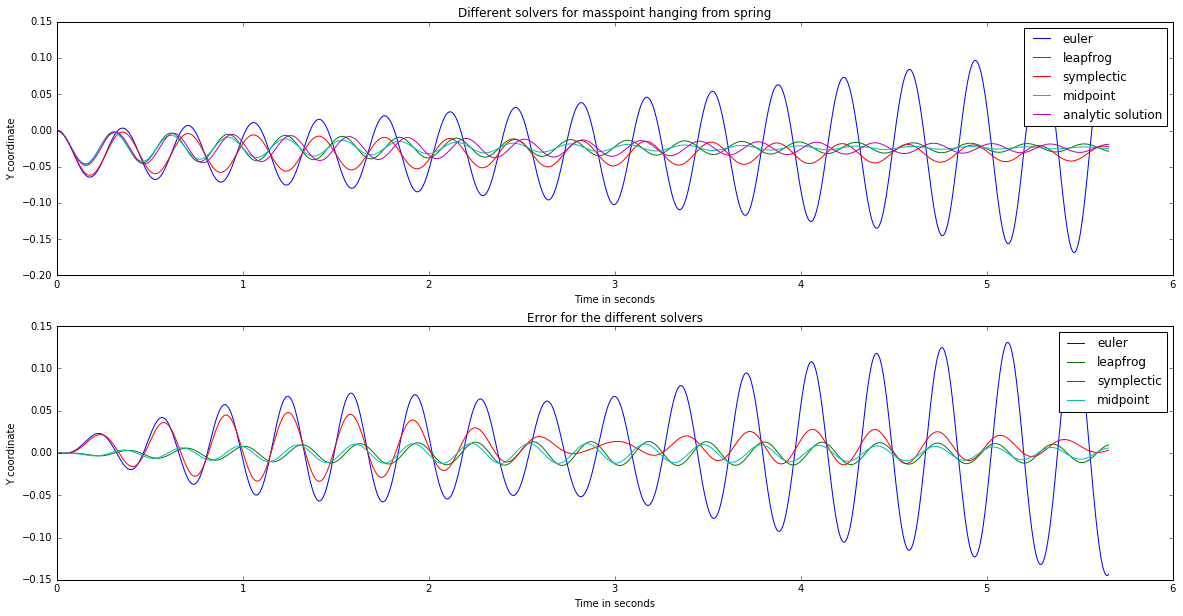

In [1]:
from math import *
import matplotlib.pyplot as plt
import numpy as np

step = 0.003
with open('euler.txt') as e:
    euler = [float(x.strip()) for x in e.readlines()]
with open('lfrog.txt') as l:
    lfrog = [float(x.strip()) for x in l.readlines()]
with open('symp.txt') as s:
    symp = [float(x.strip()) for x in s.readlines()]
with open('midpoint.txt') as m:
    midpoint = [float(x.strip()) for x in m.readlines()]

analyticSolution = np.vectorize(lambda t: 0.000327029 * np.exp(-0.266667 * t) * sin(19.9982 * t)
                                          + 0.024545 * np.exp(-0.266667 * t) * cos(19.9982 * t) - 0.024545)

# limit them to  the same length
min_len = min(len(euler), len(lfrog), len(symp), len(midpoint))
euler = euler[:min_len]
lfrog = lfrog[:min_len]
symp = symp[:min_len]
midpoint = midpoint[:min_len]

timeSteps = np.arange(min_len) * step
analytic = analyticSolution(timeSteps)

plt.figure(figsize=(20, 10))
plt.subplot(211)
plt.title('Different solvers for masspoint hanging from spring')
plt.plot(timeSteps, euler, label='euler')
plt.plot(timeSteps, lfrog, label='leapfrog')
plt.plot(timeSteps, symp, label='symplectic')
plt.plot(timeSteps, midpoint, label='midpoint')
plt.plot(timeSteps, analytic, label='analytic solution')
plt.xlabel('Time in seconds')
plt.ylabel('Y coordinate')
plt.legend()

plt.subplot(212)
plt.title('Error for the different solvers')
plt.plot(timeSteps, analytic - euler, label='euler')
plt.plot(timeSteps, analytic - lfrog, label='leapfrog')
plt.plot(timeSteps, analytic - symp, label='symplectic')
plt.plot(timeSteps, analytic - midpoint, label='midpoint')
plt.xlabel('Time in seconds')
plt.ylabel('Y coordinate')
plt.legend()

plt.show()